# Analyse et nettoyage des données Immatriculation

## Import

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import BooleanType, FloatType
from pyspark.sql.functions import trim, lower, upper, col, count, regexp_replace, max, min, when,avg, round, rand

## Session spark

In [2]:
spark = SparkSession.builder\
    .appName("CleanImmatriculation")\
    .enableHiveSupport()\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 09:29:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Import des données

In [3]:
spark.sparkContext.setLogLevel("OFF")
spark.catalog.clearCache()
spark.sql("USE concessionnaire")

df_immat = spark.sql("SELECT * FROM immatriculations_ext")
df_client = spark.sql("SELECT * FROM clients")


In [4]:
df_immat.show()
df_client.show()
df_client.count()

+---------------+----------+----------------+---------+-----------+--------+--------+-------+--------+-----+
|immatriculation|    marque|             nom|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+----------+----------------+---------+-----------+--------+--------+-------+--------+-----+
|     9046 WY 64|     Volvo|          S80 T6|      272|tr�s longue|       5|       5|   bleu|   false|50500|
|     2140 LD 19|      Audi|          A2 1.4|       75|     courte|       5|       5|   bleu|   false|18310|
|     2313 HC 20|    Nissan|   Maxima 3.0 V6|      200|tr�s longue|       5|       5|  blanc|   false|30000|
|     6582 PQ 39|      Audi|          A2 1.4|       75|     courte|       5|       5|   noir|    true|12817|
|     4947 HE 79|   Peugeot|        1007 1.4|       75|     courte|       5|       5|   gris|   false|13750|
|     3072 VZ 55|      Audi|          A2 1.4|       75|     courte|       5|       5|   noir|   false|18310|
|     6074 VK 88|Vo

100001

## Analyse

### Casse
- Renommage de la colonne "nom" en "modele" dans la table **immatriculation**
- Normalisation des marques de la table **immatriculation**
- Normalisation des modèles de la table **immatriculation**
- Suppression de la 1ère ligne de la table **clients**

#### Traitement Immatriculation

In [5]:
#Renommage de la colonne "nom" en "modele"
df_immat = df_immat.withColumnRenamed("nom", "modele")

In [6]:
df_immat.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: string (nullable = true)
 |-- prix: integer (nullable = true)



In [7]:
#Normalisation des casses
df_immat = df_immat.withColumn("marque", lower(trim(col("marque"))))
df_immat = df_immat.withColumn("modele", lower(trim(col("modele"))))
df_immat = df_immat.withColumn("immatriculation", upper(trim(col("immatriculation"))))

In [8]:
df_immat.show(n=5)

+---------------+-------+-------------+---------+-----------+--------+--------+-------+--------+-----+
|immatriculation| marque|       modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+-------+-------------+---------+-----------+--------+--------+-------+--------+-----+
|     9046 WY 64|  volvo|       s80 t6|      272|tr�s longue|       5|       5|   bleu|   false|50500|
|     2140 LD 19|   audi|       a2 1.4|       75|     courte|       5|       5|   bleu|   false|18310|
|     2313 HC 20| nissan|maxima 3.0 v6|      200|tr�s longue|       5|       5|  blanc|   false|30000|
|     6582 PQ 39|   audi|       a2 1.4|       75|     courte|       5|       5|   noir|    true|12817|
|     4947 HE 79|peugeot|     1007 1.4|       75|     courte|       5|       5|   gris|   false|13750|
+---------------+-------+-------------+---------+-----------+--------+--------+-------+--------+-----+
only showing top 5 rows



#### Traitemment Client

In [9]:
#Suppression de la 1ère ligne de la table clients
df_client = df_client.filter(df_client['immatriculation'] != 'immatriculation')

#Normalisation de situation familiale et immatriculation
df_client = df_client.withColumn("situationfamiliale", lower(trim(col("situationfamiliale"))))
df_client = df_client.withColumn("immatriculation", upper(trim(col("immatriculation"))))

In [10]:
df_client.show(n=3)

+---+----+----+------------------+---------------+---------------+---------------+
|age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+----+----+------------------+---------------+---------------+---------------+
| 40|   M| 400|         en couple|              1|          false|     7982 PU 33|
| 42|   M| 525|         en couple|              1|          false|     7501 DZ 26|
| 28|   M|1066|       c�libataire|              0|          false|     6461 JH 46|
+---+----+----+------------------+---------------+---------------+---------------+
only showing top 3 rows



### Recherche des caractères spéciaux

- Recherche du symbole "�"
- Recherche du caractère "ã©"

In [11]:
df_client.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: integer (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: boolean (nullable = true)
 |-- immatriculation: string (nullable = true)



In [12]:
#Recherche du symbole "�"

#table immatriculation
df_search_special_char_immat = df_immat.filter(
    col("immatriculation").like("%�%") | 
    col("marque").like("%�%") | 
    col("modele").like("%�%") | 
    col("longueur").like("%�%") |
    col("couleur").like("%�%") | 
    col("occasion").like("%�%")
)

#table clients
df_search_special_char_client = df_client.filter(
    col("sexe").like("%�%") |
    col("immatriculation").like("%�%")
)

value_client = df_client.groupBy("situationfamiliale").count()


In [13]:
df_search_special_char_immat.show()
df_search_special_char_client.show()
value_client.show()

+---------------+--------+----------------+---------+-----------+--------+--------+-------+--------+-----+
|immatriculation|  marque|          modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+--------+----------------+---------+-----------+--------+--------+-------+--------+-----+
|     9046 WY 64|   volvo|          s80 t6|      272|tr�s longue|       5|       5|   bleu|   false|50500|
|     2313 HC 20|  nissan|   maxima 3.0 v6|      200|tr�s longue|       5|       5|  blanc|   false|30000|
|     2341 PE 19|  nissan|   maxima 3.0 v6|      200|tr�s longue|       5|       5|  rouge|   false|30000|
|     1980 SI 38|   skoda|   superb 2.8 v6|      193|tr�s longue|       5|       5|   bleu|   false|31790|
|     8903 JY 59|mercedes|            s500|      306|tr�s longue|       5|       5|   noir|    true|70910|
|     6493 FU 73|     bmw|              m5|      507|tr�s longue|       5|       5|   bleu|    true|66360|
|     9537 BF 14| renault|vel satis 3

+---+----+----+------------------+---------------+---------------+---------------+
|age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+----+----+------------------+---------------+---------------+---------------+
+---+----+----+------------------+---------------+---------------+---------------+



+------------------+-----+
|situationfamiliale|count|
+------------------+-----+
|          mari�(e)|  635|
|             seule| 4787|
|       c�libataire|29862|
|              seul|  298|
|               n/d|   94|
|                  |   97|
|          divorc�e|   56|
|                 ?|  115|
|         en couple|64056|
+------------------+-----+



In [14]:
#Recherche du caractère "ã©"

#table immatriculation
df_search_special_char_2_immat = df_immat.filter(
    col("immatriculation").like("%ã©%") | 
    col("marque").like("%ã©%") | 
    col("modele").like("%ã©%") | 
    col("longueur").like("%ã©%") |
    col("couleur").like("%ã©%") | 
    col("occasion").like("%ã©%")
)

#table clients
df_search_special_char_2_client = df_client.filter(
    col("sexe").like("%ã©%") | 
    col("situationfamiliale").like("%ã©%") | 
    col("immatriculation").like("%ã©%")
)

In [15]:
df_search_special_char_2_immat.show()
df_search_special_char_2_client.show()

+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+

+---+----+----+------------------+---------------+---------------+---------------+
|age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+----+----+------------------+---------------+---------------+---------------+
+---+----+----+------------------+---------------+---------------+---------------+



### Correction des caractères spéciaux

- Correction du symbole "�" dans la colonne "longueur".


In [16]:
#Correction du symbole "�" dans la colonne "longueur"

df_immat = df_immat.withColumn("longueur", regexp_replace(col("longueur"), "�", "e"))

df_client = df_client.withColumn("situationfamiliale", regexp_replace(col("situationfamiliale"), "�", "e"))


In [17]:

df_search_special_char_immat = df_immat.filter(
    col("immatriculation").like("%�%") | 
    col("marque").like("%�%") | 
    col("modele").like("%�%") | 
    col("longueur").like("%�%") |
    col("couleur").like("%�%") | 
    col("occasion").like("%�%")
)

value_client = df_client.groupBy("situationfamiliale").count()

value_client.show()

df_search_special_char_immat.show()

+------------------+-----+
|situationfamiliale|count|
+------------------+-----+
|          marie(e)|  635|
|       celibataire|29862|
|             seule| 4787|
|              seul|  298|
|               n/d|   94|
|                  |   97|
|                 ?|  115|
|         en couple|64056|
|          divorcee|   56|
+------------------+-----+



+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+



## Recherche et correction des Null

- Recherche des null

In [18]:

#Recherche des null

# Liste des colonnes du DataFrame
colonnes_immat = df_immat.columns

# Filtrer pour conserver uniquement les lignes où au moins une colonne est nulle
df_immat_nulls = df_immat.filter(
    sum(col(colonne_immat).isNull().cast("int") for colonne_immat in colonnes_immat) > 0
)

# Liste des colonnes du DataFrame
colonnes_client = df_client.columns

# Filtrer pour conserver uniquement les lignes où au moins une colonne est nulle
df_client_nulls = df_client.filter(
    sum(col(colonne_client).isNull().cast("int") for colonne_client in colonnes_client) > 0
)

In [19]:
# Afficher les lignes avec des valeurs nulles
df_immat_nulls.show()
df_client_nulls.show()

+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+

+----+----+----+------------------+---------------+---------------+---------------+
| age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+----+----+----+------------------+---------------+---------------+---------------+
|null|   M|1179|       celibataire|              0|          false|     4277 VS 97|
|null|   M| 426|         en couple|              1|          false|     1192 RE 88|
|  37|   M|null|       celibataire|              0|          false|     8980 MQ 19|
|  26|   M|null|         en couple|              3|          false|     5356 OE 81|
|  45|   M| 408|         en couple|           n

## Traitement des nulls dans la table **age**

- Analyse des valeurs inférieur à 18.
- Mettre à null les valeurs inférieures à 18 ans.
- Calculer la médiane.
- Remplacer les nulls par la médiane.

In [20]:
#Analyse des valeurs inférieur à 18.

# Ajouter une colonne qui spécifie si l'âge est inférieur à 18
df_client_age = df_client.withColumn("age_below_18", when(col("age") < 18, 1).otherwise(0))

# Compter les lignes où "age_below_18" est 1
count_grouped = df_client_age.groupBy("age_below_18").count()



In [21]:
# Afficher les résultats
count_grouped.show()


+------------+-----+
|age_below_18|count|
+------------+-----+
|           1|  103|
|           0|99897|
+------------+-----+



In [22]:
#Mettre à null les valeurs inférieures à 18 ans.
df_client = df_client.withColumn("age", when(col("age") == -1, None).otherwise(col("age")))
df_client = df_client.withColumn("age", when(col("age") == 0, None).otherwise(col("age")))

#Calculer la médiane.
mediane = df_client.approxQuantile("age", [0.5], 0.01)[0]

#Remplacer les nulls par la médiane.
df_client = df_client.withColumn("age", when(col("age").isNull(), mediane).otherwise(col("age")))

In [23]:
# Afficher la médiane
print("Médiane:", mediane)

value_client = df_client.groupBy("age").count()
value_client.show()

Médiane: 42.0


+----+-----+
| age|count|
+----+-----+
|70.0|  763|
|67.0|  789|
|69.0|  801|
|49.0| 1645|
|29.0| 2464|
|75.0|  795|
|64.0|  869|
|47.0| 1667|
|42.0| 1978|
|44.0| 1604|
|35.0| 1592|
|62.0|  810|
|18.0| 2516|
|80.0|  785|
|39.0| 1700|
|37.0| 1655|
|34.0| 1661|
|25.0| 2461|
|36.0| 1676|
|41.0| 1637|
+----+-----+
only showing top 20 rows



## Traitement de **taux**

- Nettoyer situation familiale
    - Fusionner seul/seule en Celibataire
    - Remplacer les null/? par N/D
    - Analyser les différentes proportions
    - Supprimer les N/D si les proportions le permettent

- Faire la moyenne des taux par valeur de situation familiale
- Analyser la pertinence de ces moyennes
- Remplacer les nulls
- Analyse des données hors domaine
- Correction des valeurs hors domaine (Création d'une colonne "taux_eligible")

In [24]:
#Nettoyer situation familiale

#Fusionner seul/seule en Celibataire
df_client = df_client.withColumn("situationfamiliale", regexp_replace(col("situationfamiliale"), "seule", "celibataire"))
df_client = df_client.withColumn("situationfamiliale", regexp_replace(col("situationfamiliale"), "seul", "celibataire"))
df_client = df_client.withColumn("situationfamiliale", regexp_replace(col("situationfamiliale"), "divorcee", "divorce(e)"))

# Remplacer "N/D" par null dans la colonne situationfamiliale
df_client = df_client.withColumn(
    "situationfamiliale",
    when(col("situationfamiliale") == None, "n/d").otherwise(col("situationfamiliale"))
)
df_client = df_client.withColumn(
    "situationfamiliale",
    when(trim(col("situationfamiliale")) == "", "n/d").otherwise(col("situationfamiliale"))
)
# Remplacer "?" par "N/D" dans la colonne situationfamiliale
df_client = df_client.withColumn(
    "situationfamiliale",
    regexp_replace(col("situationfamiliale"), r"\?", "n/d")
)


In [25]:
value_client = df_client.groupBy("situationfamiliale").count()
value_client.show()

+------------------+-----+
|situationfamiliale|count|
+------------------+-----+
|          marie(e)|  635|
|       celibataire|34947|
|        divorce(e)|   56|
|               n/d|  306|
|         en couple|64056|
+------------------+-----+



+------------------+-----+--------------------+
|situationfamiliale|count|          percentage|
+------------------+-----+--------------------+
|          marie(e)|  635|               0.635|
|       celibataire|34947|              34.947|
|        divorce(e)|   56|0.055999999999999994|
|               n/d|  306|               0.306|
|         en couple|64056|              64.056|
+------------------+-----+--------------------+



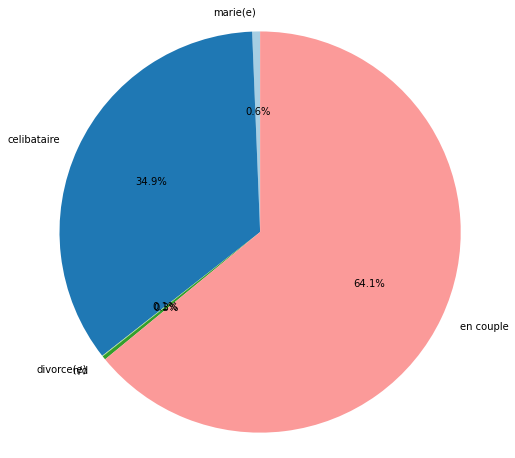

In [26]:
#Analyser les différentes proportions

df_counts = df_client.groupBy("situationfamiliale").agg(count("*").alias("count"))
total_count = df_counts.selectExpr("SUM(count) as total").collect()[0]["total"]

df_percentages = df_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Collecter les données dans un format utilisable pour Matplotlib
data = df_percentages.collect()
labels = [row["situationfamiliale"] if row["situationfamiliale"] else "Inconnue" for row in data]
sizes = [row["percentage"] for row in data]
df_percentages.show()

# Étape 2 : Créer le diagramme camembert
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct="%1.1f%%", 
    startangle=90, 
    colors=plt.cm.Paired.colors
)

plt.axis("equal")

plt.show()

In [27]:
#Supprimer les N/D car les proportions le permettent
df_client= df_client.filter(col("situationfamiliale") != "n/d")


In [28]:
df_counts = df_client.groupBy("situationfamiliale").agg(count("*").alias("count"))
total_count = df_counts.selectExpr("SUM(count) as total").collect()[0]["total"]

df_percentages = df_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Collecter les données dans un format utilisable pour Matplotlib
data = df_percentages.collect()
labels = [row["situationfamiliale"] if row["situationfamiliale"] else "Inconnue" for row in data]
sizes = [row["percentage"] for row in data]
df_percentages.show()

+------------------+-----+--------------------+
|situationfamiliale|count|          percentage|
+------------------+-----+--------------------+
|          marie(e)|  635|   0.636949064136257|
|       celibataire|34947|   35.05426605412563|
|        divorce(e)|   56|0.056171885971071485|
|         en couple|64056|   64.25261299576704|
+------------------+-----+--------------------+



In [29]:
# Faire la moyenne des taux par valeur de situation familiale
mediane_taux = df_client.groupBy("situationfamiliale").agg(
    F.expr("percentile_approx(taux, 0.5, 100)").alias("mediane_taux")
)


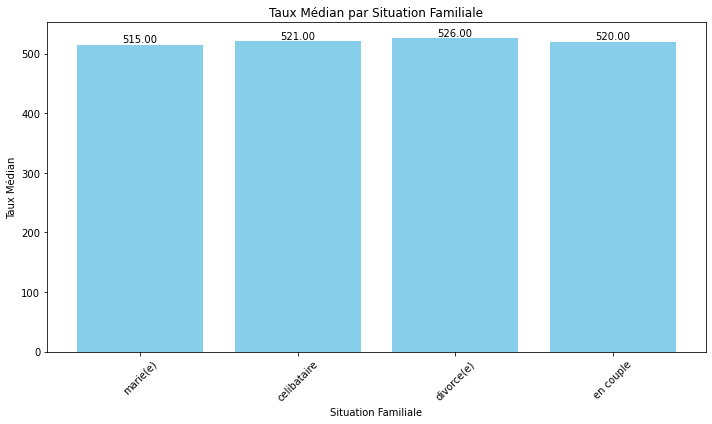

In [30]:
#Analyser la pertinence de ces moyennes

# Récupération des moyennes pour afficher dans un histogramme
data = mediane_taux.collect()
categories = [row["situationfamiliale"] for row in data]
mediane_taux = [row["mediane_taux"] for row in data]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, mediane_taux, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Situation Familiale")
plt.ylabel("Taux Médian")
plt.title("Taux Médian par Situation Familiale")
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


In [31]:
# Remplacer les nulls

mediane_taux = df_client.approxQuantile("taux", [0.5], 0.01)[0]
df_client = df_client.withColumn("taux", when(col("taux").isNull(), mediane).otherwise(col("taux")))

In [32]:
print("Médiane:", mediane_taux)

Médiane: 521.0


In [33]:
#Analyse des données hors domaine

valeurs_hors_champs_min = df_client.filter(col("taux") < 544)
valeurs_hors_champs_max = df_client.filter(col("taux") > 74185)

# Comptage des valeurs hors champ
valeurs_hors_champs_min.count()



55431

In [34]:
valeurs_hors_champs_max.count()

0

In [35]:
#Correction des valeurs hors domaine (Création d'une colonne "taux_eligible")
df_client = df_client.withColumn(
    "taux_eligible",
    when((col("taux") >= 544) & (col("taux") <= 74185), True).otherwise(False)
)

In [36]:
# Affichage des résultats
df_client.show()

+----+----+------+------------------+---------------+---------------+---------------+-------------+
| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|immatriculation|taux_eligible|
+----+----+------+------------------+---------------+---------------+---------------+-------------+
|40.0|   M| 400.0|         en couple|              1|          false|     7982 PU 33|        false|
|42.0|   M| 525.0|         en couple|              1|          false|     7501 DZ 26|        false|
|28.0|   M|1066.0|       celibataire|              0|          false|     6461 JH 46|         true|
|44.0|   F| 237.0|       celibataire|              0|          false|     8430 FZ 18|        false|
|75.0|   M| 563.0|       celibataire|              0|          false|     4429 QQ 61|         true|
|56.0|   M| 840.0|         en couple|              0|          false|     3509 CA 60|         true|
|28.0|   M| 414.0|         en couple|              2|          false|     5010 JT 73|        false|


## Traitement des null dans **nbenfantacharge**

- Faire la moyenne des enfants à charges par valeur de situation familiale
- Analyser la pertinence de ces moyennes
- Remplacer les nulls

In [37]:
# Faire la moyenne des enfants à charges par valeur de situation familiale
moyenne_enfant = df_client.groupBy("situationfamiliale").agg(
    round(avg("nbenfantacharge"), 0).cast("int").alias("moyenne_enfant")
)

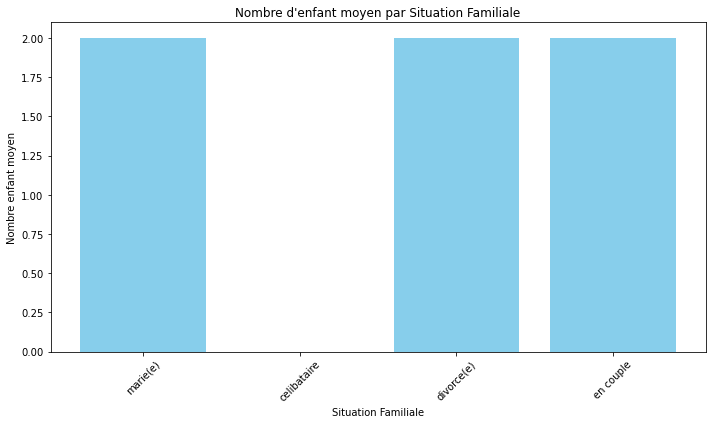

In [38]:
#Analyser la pertinence de ces moyennes

# Récupération des moyennes pour afficher dans un histogramme
data = moyenne_enfant.collect()
categories = [row["situationfamiliale"] for row in data]
moyenne_enfant = [row["moyenne_enfant"] for row in data]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, moyenne_enfant, color='skyblue')
plt.xlabel("Situation Familiale")
plt.ylabel("Nombre enfant moyen")
plt.title("Nombre d'enfant moyen par Situation Familiale")
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


In [39]:
# Filtrer les données pour les célibataires et compter les valeurs non nulles de 'nbenfantacharge'

df_celibataire = df_client.filter(col("situationfamiliale") == "celibataire")
value_client = df_celibataire.groupBy("nbenfantacharge").count()

In [40]:
value_client.show()

+---------------+-----+
|nbenfantacharge|count|
+---------------+-----+
|             -1|   28|
|              1| 1576|
|              3| 1613|
|              2| 1583|
|              0|30072|
|           null|   75|
+---------------+-----+



In [41]:
df_client = df_client.withColumn(
    "nbenfantacharge",
    when(
        (col("situationfamiliale") == "celibataire") & (col("nbenfantacharge").isNull() | (col("nbenfantacharge") == -1)),
        0
    ).otherwise(col("nbenfantacharge"))
)

df_client = df_client.withColumn(
    "nbenfantacharge",
    when(
        (col("situationfamiliale").isin("marie(e)", "divorce(e)", "en couple")) & 
        (col("nbenfantacharge").isNull() | (col("nbenfantacharge") == -1)),
        2
    ).otherwise(col("nbenfantacharge"))
)


In [42]:
value_client = df_client.groupBy("nbenfantacharge").count()
value_client.show()

+---------------+-----+
|nbenfantacharge|count|
+---------------+-----+
|              1|16482|
|              3|11486|
|              4| 9987|
|              2|16638|
|              0|45101|
+---------------+-----+



## Traitement des null dans **sexe**

- Fusionner F/F�minin/Femme en F
- Fusionner H/Masculin/Hommme en H
- Remplacer les null/? par N/D
- Analyser les différentes proportions
- Supprimer les N/D si les proportions le permettent

In [43]:
value_client = df_client.groupBy("sexe").count()
value_client.show()

+--------+-----+
|    sexe|count|
+--------+-----+
|       F|29400|
|Masculin|  701|
| F�minin|  297|
|       M|68012|
|     N/D|   87|
|   Femme|  311|
|        |   93|
|   Homme|  689|
|       ?|  104|
+--------+-----+



In [44]:
#Fusionner F/F�minin/Femme en F
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "Femme", "f"))
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "F�minin", "f"))
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "F", "f"))

#Fusionner H/M/Masculin/Hommme en H
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "Masculin", "h"))
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "M", "h"))
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "Homme", "h"))
df_client = df_client.withColumn("sexe", regexp_replace(col("sexe"), "H", "h"))

#Remplacer les null/? par N/D
df_client = df_client.withColumn("sexe", when(col("sexe") == None, "n/d").otherwise(col("sexe")))
df_client = df_client.withColumn("sexe",when(trim(col("sexe")) == "", "n/d").otherwise(col("sexe")))
df_client = df_client.withColumn("sexe",when(trim(col("sexe")) == "N/D", "n/d").otherwise(col("sexe")))
df_client = df_client.withColumn("sexe",regexp_replace(col("sexe"), r"\?", "n/d"))

In [45]:
value_client = df_client.groupBy("sexe").count()
value_client.show()

+----+-----+
|sexe|count|
+----+-----+
|   f|30008|
|   h|69402|
| n/d|  284|
+----+-----+



+----+-----+------------------+
|sexe|count|        percentage|
+----+-----+------------------+
|   f|30008|30.100106325355586|
|   h|69402| 69.61502196721969|
| n/d|  284|0.2848717074247196|
+----+-----+------------------+



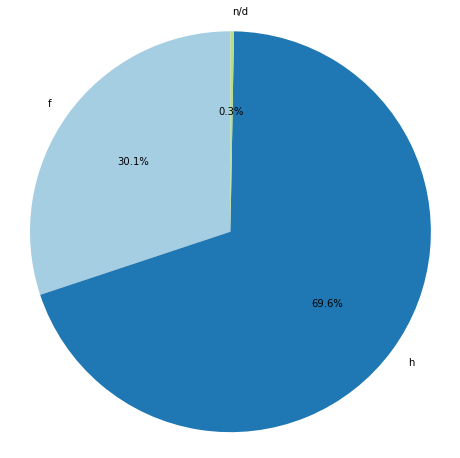

In [46]:
#Analyser les différentes proportions

df_counts = df_client.groupBy("sexe").agg(count("*").alias("count"))
total_count = df_counts.selectExpr("SUM(count) as total").collect()[0]["total"]

df_percentages = df_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Collecter les données dans un format utilisable pour Matplotlib
data = df_percentages.collect()
labels = [row["sexe"] if row["sexe"] else "Inconnue" for row in data]
sizes = [row["percentage"] for row in data]
df_percentages.show()

# Étape 2 : Créer le diagramme camembert
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct="%1.1f%%", 
    startangle=90, 
    colors=plt.cm.Paired.colors
)

plt.axis("equal")

plt.show()

In [47]:
#Supprimer les N/D si les proportions le permettent

df_client= df_client.filter(col("sexe") != "n/d")

In [48]:
value_client = df_client.groupBy("sexe").count()
value_client.show()

+----+-----+
|sexe|count|
+----+-----+
|   f|30008|
|   h|69402|
+----+-----+



## Traitement des null dans **deuxiemevoiture**

- Calculer le pourcentage true/false
- Remplacer les null en true et false en fonction des pourcentage de chacun.

In [49]:
value_client = df_client.groupBy("deuxiemevoiture").count()
value_client.show()

+---------------+-----+
|deuxiemevoiture|count|
+---------------+-----+
|           true|12916|
|          false|86301|
|           null|  193|
+---------------+-----+



In [50]:
#Calculer le pourcentage true/false

df_filtered = df_client.filter(col("deuxiemevoiture").isNotNull())
df_counts = df_filtered.groupBy("deuxiemevoiture").agg(count("*").alias("count"))
total_count = df_counts.selectExpr("SUM(count) as total").collect()[0]["total"]

df_percentages = df_counts.withColumn("percentage", (col("count") / total_count) * 100)

df_percentages.show()

+---------------+-----+------------------+
|deuxiemevoiture|count|        percentage|
+---------------+-----+------------------+
|           true|12916|13.017930394992794|
|          false|86301| 86.98206960500721|
+---------------+-----+------------------+



In [51]:
#Remplacer les null en true et false en fonction des pourcentage de chacun.

df_nulls = df_client.filter(col("deuxiemevoiture").isNull())

# Ajouter une colonne aléatoire et assigner 'true' ou 'false' selon les proportions
df_nulls_replaced = df_nulls.withColumn(
    "deuxiemevoiture",
    when(rand() < 0.13, True).otherwise(False)
)

# Filtrer les lignes sans 'null' dans 'deuxiemevoiture'
df_non_nulls = df_client.filter(col("deuxiemevoiture").isNotNull())

# Combiner les deux DataFrames
df_client = df_non_nulls.union(df_nulls_replaced)


In [52]:
df_counts = df_client.groupBy("deuxiemevoiture").agg(count("*").alias("count"))
total_count = df_counts.selectExpr("SUM(count) as total").collect()[0]["total"]

df_percentages = df_counts.withColumn("percentage", (col("count") / total_count) * 100)

df_percentages.show()

+---------------+-----+------------------+
|deuxiemevoiture|count|        percentage|
+---------------+-----+------------------+
|           true|12932|13.008751634644403|
|          false|86478|  86.9912483653556|
+---------------+-----+------------------+



## Traitement des null dans **immatriculation**

- Compter les null
- Compter les doublons
- Analyser les doublons
- Suppression des doublons

In [53]:
#Compter les null
df_null_counts = df_client.select(
    count(col("immatriculation")).alias("non_null"),
    count(when(col("immatriculation").isNull(), 1)).alias("null")
)

# Afficher le résultat
df_null_counts.show()

+--------+----+
|non_null|null|
+--------+----+
|   99410|   0|
+--------+----+



In [54]:
#Compter les doublons

df_duplicates = (
    df_client.groupBy("immatriculation")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)  # Filtrer les doublons (où le compte est > 1)
)

# Afficher les résultats
df_duplicates.show()

#Analyser les doublons

duplicate_values = (
    df_client.groupBy("immatriculation")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)  # Garde seulement les doublons
    .select("immatriculation")  # Récupère uniquement la colonne des doublons
)

df_duplicate_rows = df_client.join(
    duplicate_values, on="immatriculation", how="inner"
)

# Afficher les lignes des doublons
df_duplicate_rows.show()

+---------------+-----+
|immatriculation|count|
+---------------+-----+
|     8521 UI 89|    2|
|     5823 ED 28|    2|
|     8415 YL 81|    2|
|     7397 EO 93|    2|
|     8468 FV 64|    2|
|     1033 TS 14|    2|
|     8688 PZ 88|    2|
|     2246 KE 86|    2|
|     4177 DH 15|    2|
+---------------+-----+



+---------------+----+----+------+------------------+---------------+---------------+-------------+
|immatriculation| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|
+---------------+----+----+------+------------------+---------------+---------------+-------------+
|     7397 EO 93|26.0|   h| 480.0|         en couple|              2|          false|        false|
|     5823 ED 28|53.0|   f| 585.0|         en couple|              1|          false|         true|
|     8521 UI 89|56.0|   h| 516.0|       celibataire|              0|          false|        false|
|     1033 TS 14|65.0|   h| 590.0|       celibataire|              0|          false|         true|
|     4177 DH 15|52.0|   h| 464.0|         en couple|              1|          false|        false|
|     2246 KE 86|55.0|   h| 155.0|         en couple|              2|          false|        false|
|     8468 FV 64|44.0|   h| 408.0|         en couple|              3|          false|        false|


In [55]:
#Suppression des doublons
df_client= df_client.dropDuplicates(["immatriculation"])

In [56]:
df_duplicates = (
    df_client.groupBy("immatriculation")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)  # Filtrer les doublons (où le compte est > 1)
)

# Afficher les résultats
df_duplicates.show()


+---------------+-----+
|immatriculation|count|
+---------------+-----+
+---------------+-----+



## Modification du type des colonnes occasion

- Recherche des valeurs d'occasion
- Changer le type de la colonne

In [57]:
#Recherche des valeurs d'occasion
value_count_occasion = df_immat.groupBy("occasion").count()

value_count_occasion.show()

+--------+-------+
|occasion|  count|
+--------+-------+
|   false|1374510|
|    true| 625490|
+--------+-------+



In [58]:
#Changer le type de la colonne
df_immat = df_immat.withColumn("occasion", df_immat["occasion"].cast(BooleanType()))

df_immat.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: boolean (nullable = true)
 |-- prix: integer (nullable = true)



## Recherche de valeurs aberrantes

- Modéliser les valeurs dans un diagramme à moustaches pour mettre en avant les valeurs aberrantes.
- Afficher les valeurs suspectes.

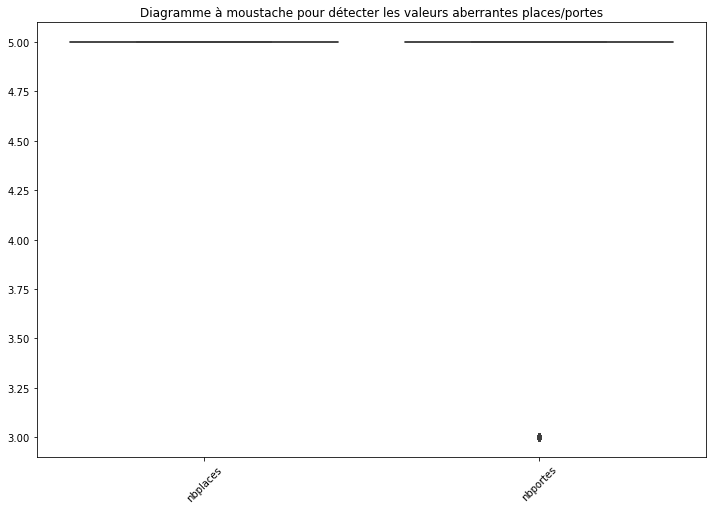

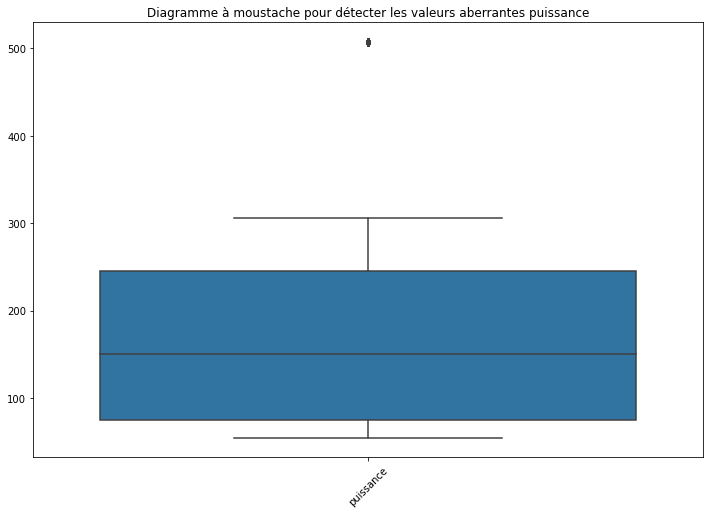

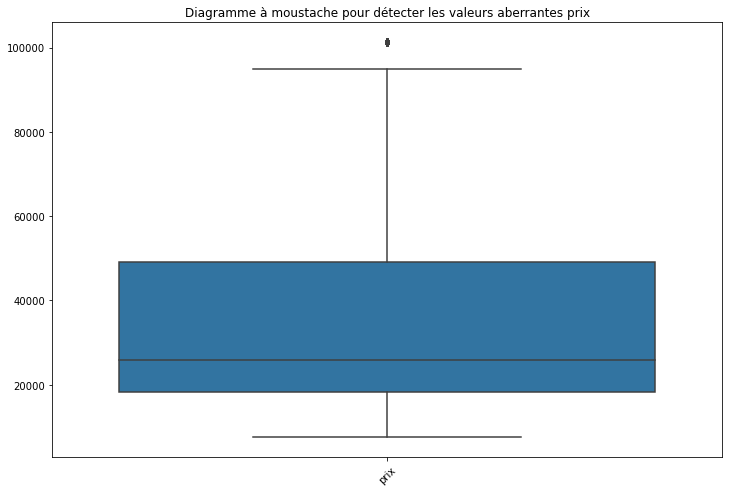

In [59]:
#Modéliser les valeurs dans un diagramme à moustaches pour mettre en avant les valeurs aberrantes.

# 2. Sélectionner uniquement les colonnes numériques nécessaires

df_place_porte = df_immat.select(["nbplaces", "nbportes"])
df_prix = df_immat.select(["prix"])
df_puissance = df_immat.select(["puissance"])

# 3. Convertir le DataFrame PySpark en DataFrame Pandas
df_place_porte= df_place_porte.toPandas()
df_prix= df_prix.toPandas()
df_puissance= df_puissance.toPandas()

# 4. Tracer le diagramme à moustaches pour chaque colonne
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_place_porte)
plt.title("Diagramme à moustache pour détecter les valeurs aberrantes places/portes")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_puissance)
plt.title("Diagramme à moustache pour détecter les valeurs aberrantes puissance")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_prix)
plt.title("Diagramme à moustache pour détecter les valeurs aberrantes prix")
plt.xticks(rotation=45)
plt.show()

In [60]:
#Afficher les valeurs suspectes.

# Trouver la valeur maximale de la colonne "prix"
prix_max = df_immat.select(max("prix")).collect()[0][0]

# Filtrer le DataFrame pour afficher les lignes ayant cette valeur
df_max_prix = df_immat.filter(df_immat["prix"] == prix_max)

# Afficher les lignes avec le prix maximum
df_max_prix.show()

# Trouver la valeur maximale de la colonne "prix"
prix_min = df_immat.select(min("prix")).collect()[0][0]

# Filtrer le DataFrame pour afficher les lignes ayant cette valeur
df_min_prix = df_immat.filter(df_immat["prix"] == prix_min)

# Afficher les lignes avec le prix maximum
df_min_prix.show()

+---------------+--------+------+---------+-----------+--------+--------+-------+--------+------+
|immatriculation|  marque|modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion|  prix|
+---------------+--------+------+---------+-----------+--------+--------+-------+--------+------+
|     3138 PY 76|mercedes|  s500|      306|tres longue|       5|       5|  rouge|   false|101300|
|     1442 FF 73|mercedes|  s500|      306|tres longue|       5|       5|   noir|   false|101300|
|     4765 XY 48|mercedes|  s500|      306|tres longue|       5|       5|  blanc|   false|101300|
|     2223 XE 76|mercedes|  s500|      306|tres longue|       5|       5|  rouge|   false|101300|
|     6694 KP 49|mercedes|  s500|      306|tres longue|       5|       5|   noir|   false|101300|
|     9581 UG 51|mercedes|  s500|      306|tres longue|       5|       5|   gris|   false|101300|
|     6247 XB 98|mercedes|  s500|      306|tres longue|       5|       5|   noir|   false|101300|
|     3200 FP 58|mer

## Fusion des tables **client** et **immatriculation**

In [61]:
#Fusion des tables
df_client_immat= df_client.join(df_immat, on= "immatriculation")

In [62]:
df_client_immat.show()
df_client.count()

+---------------+----+----+------+------------------+---------------+---------------+-------------+----------+----------------+---------+-----------+--------+--------+-------+--------+------+
|immatriculation| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|    marque|          modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion|  prix|
+---------------+----+----+------+------------------+---------------+---------------+-------------+----------+----------------+---------+-----------+--------+--------+-------+--------+------+
|     9175 TL 69|23.0|   h| 591.0|         en couple|              1|          false|         true|      saab|        9.3 1.8t|      150|     longue|       5|       5|   bleu|    true| 27020|
|     3706 ZJ 29|51.0|   h| 506.0|         en couple|              1|           true|        false|   renault|vel satis 3.5 v6|      245|tres longue|       5|       5|   bleu|   false| 49200|
|     9196 GA 50|23.0|   h| 531.0|      

99401

In [63]:
#Nombre de match
match_count=df_client_immat.count()

print(f"Nombre de correspondances (matchs) : {match_count}")

Nombre de correspondances (matchs) : 99733


In [64]:
#Compter les doublons
df_duplicates = (
    df_client_immat.groupBy("immatriculation")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)  # Filtrer les doublons (où le compte est > 1)
)

# Afficher les résultats
df_duplicates.count()


332

In [65]:
#Analyser les doublons
duplicate_values = (
    df_client_immat.groupBy("immatriculation")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)  # Filtrer les doublons
    .select("immatriculation")  # Récupérer les valeurs des doublons
)

# Étape 2 : Joindre pour récupérer les lignes correspondantes
df_duplicate_rows = df_client_immat.join(
    duplicate_values, on="immatriculation", how="inner"
)

# Étape 3 : Ordonnancer par 'immatriculation' et afficher une seule ligne
df_duplicate_rows.orderBy("immatriculation").show(10)

+---------------+----+----+-----+------------------+---------------+---------------+-------------+----------+-------------+---------+-----------+--------+--------+-------+--------+-----+
|immatriculation| age|sexe| taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|    marque|       modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+----+----+-----+------------------+---------------+---------------+-------------+----------+-------------+---------+-----------+--------+--------+-------+--------+-----+
|     1033 TS 14|65.0|   h|590.0|       celibataire|              0|          false|         true|  mercedes|         a200|      136|    moyenne|       5|       5|  blanc|    true|18130|
|     1033 TS 14|65.0|   h|590.0|       celibataire|              0|          false|         true|   peugeot|     1007 1.4|       75|     courte|       5|       5|   bleu|   false|13750|
|     1044 ZL 59|23.0|   h|762.0|         en couple|             

In [66]:
#Supression des doublons
df_client_immat= df_client_immat.dropDuplicates(["immatriculation"])

In [67]:
df_duplicates = (
    df_client_immat.groupBy("immatriculation")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)  # Filtrer les doublons (où le compte est > 1)
)

# Afficher les résultats
df_duplicates.count()

0

In [68]:
df_client_immat.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: boolean (nullable = true)
 |-- taux_eligible: boolean (nullable = false)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: boolean (nullable = true)
 |-- prix: integer (nullable = true)



In [69]:
# Ajout de la colonne 'categorie' avec des critères précis
df_client_immat= df_client_immat.withColumn(
    "categorie",
    when(
        (col("longueur") == "courte") & (col("puissance") < 100) & (col("prix") < 20000),
        "citadine economique"
    )
    .when(
        (col("longueur") == "courte") & (col("puissance") >= 100) & (col("prix") >= 20000),
        "citadine standard"
    )
    .when(
        (col("longueur").isin("moyenne", "longue")) & (col("nbplaces") >= 5) & (col("prix") < 35000),
        "familiale"
    )
    .when(
        (col("longueur").isin("longue", "tres longue")) & (col("nbplaces") >= 5) & (col("prix") >= 35000),
        "suv/crossover"
    )
    .when(
        (col("puissance") >= 200) & (col("prix") >= 40000),
        "sportive"
    )
    .when(
        (col("prix") >= 50000),
        "luxe"
    )
    .otherwise("autre")
)

In [70]:
df_client_immat.show()

+---------------+----+----+------+------------------+---------------+---------------+-------------+----------+--------------+---------+-----------+--------+--------+-------+--------+-----+-------------------+
|immatriculation| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|    marque|        modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|          categorie|
+---------------+----+----+------+------------------+---------------+---------------+-------------+----------+--------------+---------+-----------+--------+--------+-------+--------+-----+-------------------+
|        0 WQ 28|61.0|   h|1213.0|       celibataire|              0|          false|         true|  mercedes|          a200|      136|    moyenne|       5|       5|   gris|   false|25900|          familiale|
|        1 DH 28|84.0|   h| 520.0|       celibataire|              0|          false|        false|   peugeot|      1007 1.4|       75|     courte|       5|       5